In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from keras.utils.vis_utils import plot_model


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_colwidth', None)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.99.251.234:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.99.251.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.99.251.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [22]:
# import train and validation sets 
path = '/content/drive/MyDrive/Colab Notebooks/BT5153/Kaggle/Colab Data/'
X_train = pd.read_csv(path+'X_train.csv')
X_val = pd.read_csv(path+'X_val.csv')
y_train = pd.read_csv(path+'y_train.csv')
y_val = pd.read_csv(path+'y_val.csv')

In [23]:
X_train = X_train.cleaned_text.tolist()
X_val = X_val.cleaned_text.tolist()
y_train = y_train.Outcome.tolist()
y_val = y_val.Outcome.tolist()

### Word-level CNN

In [24]:
## Import Packages
from keras.models import Model
import numpy as np
from keras.layers import Input, Dense, Embedding, Activation, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, SimpleRNN,Bidirectional

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [25]:
vocab_size =  300000
tk = Tokenizer(num_words=vocab_size) 
tk.fit_on_texts(X_train)

In [26]:
# Convert string to index
train_sequences = tk.texts_to_sequences(X_train)
val_texts = tk.texts_to_sequences(X_val)

In [27]:
sequence_length = 300
# Padding
train_data = pad_sequences(train_sequences, maxlen=sequence_length, padding='post')
val_data = pad_sequences(val_texts, maxlen=sequence_length, padding='post')

In [28]:
# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
val_data = np.array(val_data, dtype='float32')
train_classes = np.array(y_train, dtype='int')
val_classes = np.array(y_val, dtype='int')

In [29]:
save_model_path = '/content/drive/MyDrive/Colab Notebooks/BT5153/Kaggle/models'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

model_name = 'model_no_pretrained_final.h5'


with tpu_strategy.scope():

  embedding_dim = 50    # The size of embedding
  input_shape = (sequence_length,)
  model_input = Input(shape=input_shape)

  # Embedding Layer
  z_cnn = Embedding(vocab_size, embedding_dim, input_length=sequence_length, name="embedding")(model_input)

  # Convolutional Layer 
  conv_blocks = []
  #capture two-grams, 3-grams and 4 grams
  filter_sizes = [2,3,4]
  #for each filter, the number of filters
  num_filters = 30
  #loop over the different filter sizes
  for sz in filter_sizes:
      # sz is the window size
      conv = Conv1D(filters=num_filters,
                    kernel_size=sz,
                    padding="valid",
                    activation="relu",
                    strides=1)(z_cnn)
      # Pooling Layer
      conv = GlobalMaxPooling1D()(conv)
      conv_blocks.append(conv)
  # Fully-connected Layer
  hiddenz = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

  model_output = Dense(16, activation="softmax")(hiddenz)

  optimizer =tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode="auto")
  earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

  cnn_model = Model(model_input, model_output)
  cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
  
cnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 50)      15000000    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 299, 30)      3030        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 298, 30)      4530        embedding[0][0]                  
____________________________________________________________________________________________

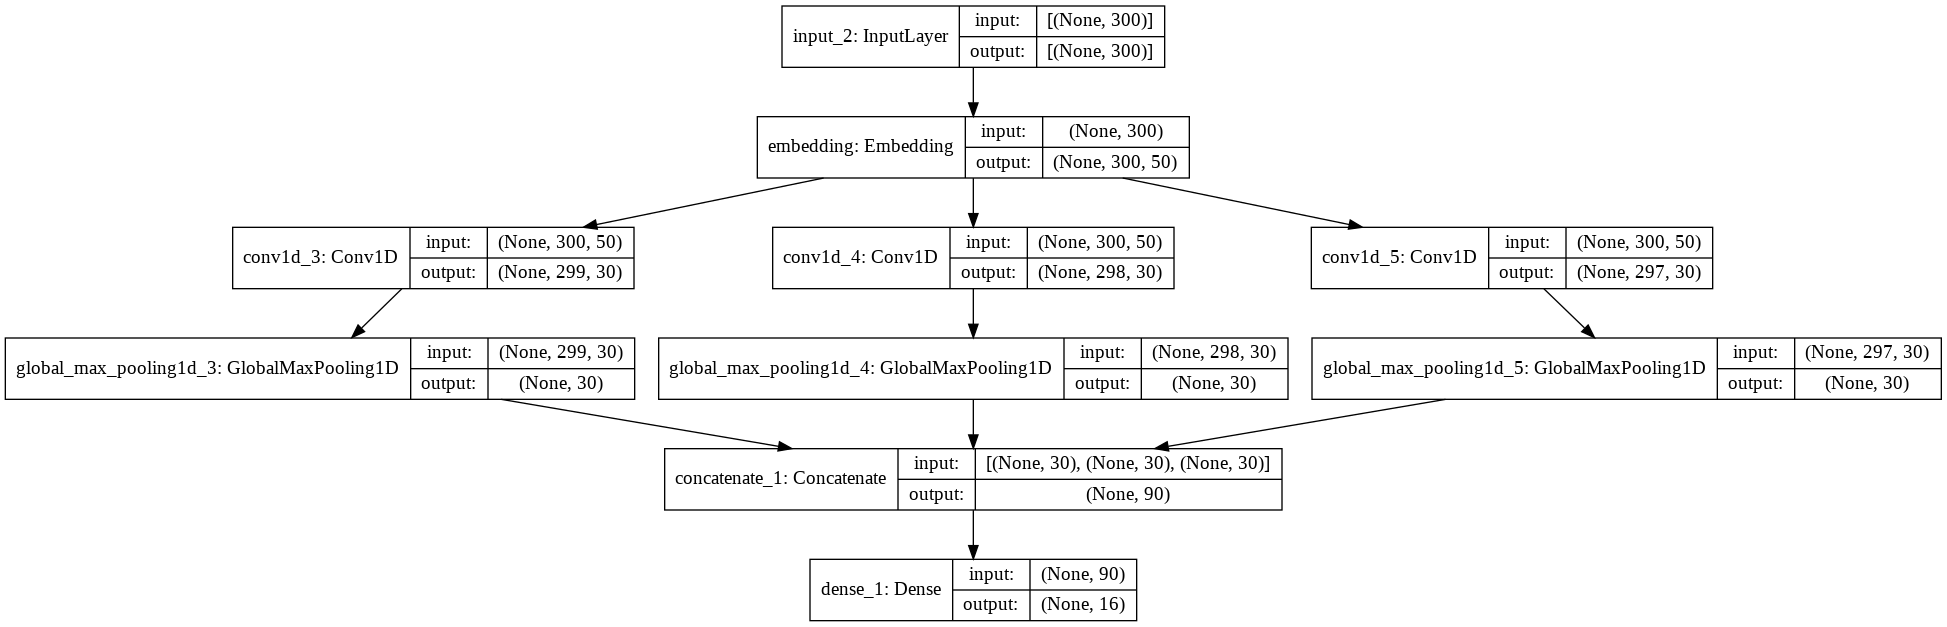

In [30]:
tf.keras.utils.plot_model(
    cnn_model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [31]:
# balance class weights

import collections
counter = collections.Counter(train_classes)
class_weights = {}

for i in range(16):
  class_weights[i] = (1 / counter[i]) * len(train_classes) / 2.0

In [32]:
# Training
try:
  cnn_model.fit(train_data, train_classes,
            validation_data=(val_data, val_classes),
            batch_size=32,
            epochs=20,
            verbose=1,
            callbacks=[lr_scheduler, earlystopping],
            class_weight=class_weights)
except KeyboardInterrupt:
  print('\nInterrupt received, stopping')

finally:
  pass

Epoch 1/20
22394/22394 [==============================] - 639s 28ms/step - loss: 6.5140 - accuracy: 0.8172 - val_loss: 0.3434 - val_accuracy: 0.8994
Epoch 2/20
22394/22394 [==============================] - 644s 29ms/step - loss: 2.4455 - accuracy: 0.9141 - val_loss: 0.3019 - val_accuracy: 0.9108
Epoch 3/20
22394/22394 [==============================] - 649s 29ms/step - loss: 1.8577 - accuracy: 0.9282 - val_loss: 0.3325 - val_accuracy: 0.9021
Epoch 4/20
22394/22394 [==============================] - 642s 29ms/step - loss: 1.4697 - accuracy: 0.9381 - val_loss: 0.3227 - val_accuracy: 0.9089

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
22394/22394 [==============================] - 641s 29ms/step - loss: 1.0258 - accuracy: 0.9524 - val_loss: 0.3151 - val_accuracy: 0.9137
Epoch 00005: early stopping


In [33]:
# save cnn model
cnn_model.save(os.path.join(save_model_path, model_name))

In [34]:
val_pred = cnn_model.predict(val_data, batch_size=64)
pred = val_pred.argmax(axis=1)

# macro score
macro_f1_score = f1_score(val_classes, pred, average='macro')
print(macro_f1_score)

0.8142076757620335


In [35]:
# val set
val_pred_proba = cnn_model.predict(val_data, batch_size=64)
np.save(path+'val_pred_proba.npy', val_pred_proba)

In [36]:
# test set
df_test = pd.read_csv(path+'test_all_features.csv')
df_test.fillna(value='na', inplace=True)
test_texts = tk.texts_to_sequences(df_test['cleaned_text'].tolist())
test_data = pad_sequences(test_texts, maxlen=sequence_length, padding='post')
test_data = np.array(test_data, dtype='float32')

pred = cnn_model.predict(test_data, batch_size=64)
np.save(path+'test_pred_proba.npy', pred)